In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 2000

data = pd.DataFrame({
    "order_time": pd.to_datetime("2025-01-01") + pd.to_timedelta(np.random.randint(0, 720, n), unit="h"),
    "dispatch_delay_hrs": np.random.uniform(0.5, 6, n),
    "distance_km": np.random.uniform(1, 120, n),
    "traffic_level": np.random.choice(["Low", "Medium", "High"], n),
    "weather": np.random.choice(["Clear", "Rain", "Storm"], n),
    "courier_partner": np.random.choice(["A", "B", "C"], n)
})

data["dispatch_time"] = data["order_time"] + pd.to_timedelta(data["dispatch_delay_hrs"], unit="h")
data["promised_delivery_hrs"] = data["distance_km"] / 30 + 5
data["actual_delivery_hrs"] = (
    data["promised_delivery_hrs"]
    + np.where(data["traffic_level"] == "High", 3, 0)
    + np.where(data["weather"] != "Clear", 2, 0)
    + np.random.normal(0, 1, n)
)

data["is_delayed"] = (data["actual_delivery_hrs"] > data["promised_delivery_hrs"]).astype(int)

data.head()



,order_time,dispatch_delay_hrs,distance_km,traffic_level,weather,courier_partner,dispatch_time,promised_delivery_hrs,actual_delivery_hrs,is_delayed
0,2025-01-05 06:00:00,5.255349,103.773329,High,Storm,C,2025-01-05 11:15:19.254951910,8.459111,13.494888,1
1,2025-01-19 03:00:00,4.726857,14.097531,Low,Rain,C,2025-01-19 07:43:36.683417571,5.469918,7.298399,1
2,2025-01-12 06:00:00,1.122104,111.080614,Medium,Clear,A,2025-01-12 07:07:19.574417715,8.702687,7.623998,0
3,2025-01-05 10:00:00,4.875307,76.165578,Low,Rain,A,2025-01-05 14:52:31.105359588,7.538853,9.723807,1
4,2025-01-03 23:00:00,5.552728,7.472499,High,Rain,B,2025-01-04 04:33:09.820380470,5.249083,10.641190,1


In [2]:
data["is_delayed"].value_counts(normalize=True)


is_delayed
1    0.87
0    0.13
Name: proportion, dtype: float64

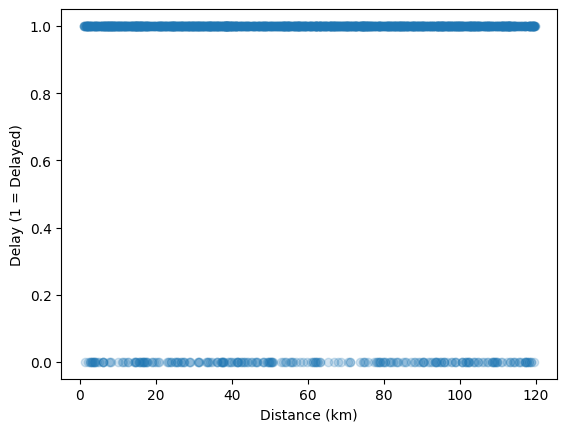

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data["distance_km"], data["is_delayed"], alpha=0.2)
plt.xlabel("Distance (km)")
plt.ylabel("Delay (1 = Delayed)")
plt.show()


In [4]:
pd.crosstab(data["traffic_level"], data["is_delayed"], normalize="index")


is_delayed,0,1
traffic_level,,
High,0.001529,0.998471
Low,0.191843,0.808157
Medium,0.192982,0.807018


In [6]:
from sklearn.preprocessing import LabelEncoder

df = data.drop(columns=["order_time", "dispatch_time", "actual_delivery_hrs"])

for col in ["traffic_level", "weather", "courier_partner"]:
    df[col] = LabelEncoder().fit_transform(df[col])


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df.drop("is_delayed", axis=1)
y = df["is_delayed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.43      0.51        53
           1       0.92      0.96      0.94       347

    accuracy                           0.89       400
   macro avg       0.76      0.70      0.72       400
weighted avg       0.88      0.89      0.88       400



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))


              precision    recall  f1-score   support

           0       0.53      0.83      0.65        53
           1       0.97      0.89      0.93       347

    accuracy                           0.88       400
   macro avg       0.75      0.86      0.79       400
weighted avg       0.91      0.88      0.89       400

ROC-AUC: 0.8961448534609321


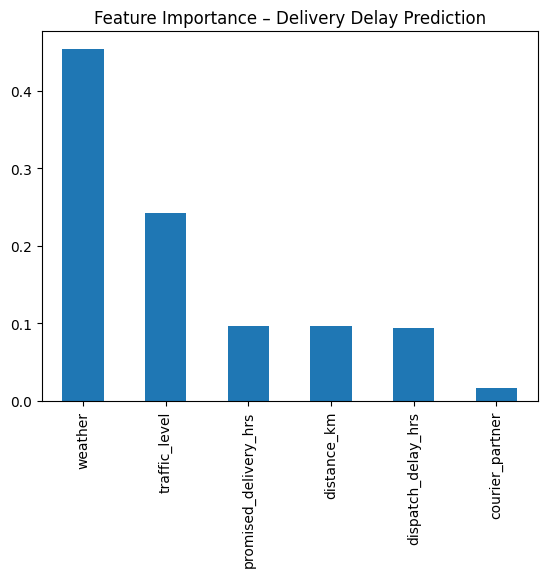

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.plot(kind="bar")
plt.title("Feature Importance – Delivery Delay Prediction")
plt.show()


In [10]:
error_df = X_test.copy()
error_df["actual"] = y_test.values
error_df["predicted"] = rf_pred

error_df[error_df["actual"] != error_df["predicted"]].head()


,dispatch_delay_hrs,distance_km,traffic_level,weather,courier_partner,promised_delivery_hrs,actual,predicted
1860,5.611086,7.811167,2,0,2,5.260372,0,1
1333,4.125126,53.199053,1,0,0,6.773302,1,0
674,2.276562,74.123808,2,0,0,7.470794,1,0
1083,3.980985,71.168766,1,1,2,7.372292,0,1
628,3.538825,113.224366,2,0,0,8.774146,1,0


In [11]:
import joblib
joblib.dump(rf_model, "../model/delivery_delay_model.pkl")


['../model/delivery_delay_model.pkl']

In [13]:
import joblib

model = joblib.load("../model/delivery_delay_model.pkl")
print("Model loaded successfully")


Model loaded successfully


In [14]:
type(model)


sklearn.ensemble._forest.RandomForestClassifier

In [15]:
X.columns.tolist()


['dispatch_delay_hrs',
 'distance_km',
 'traffic_level',
 'weather',
 'courier_partner',
 'promised_delivery_hrs']

In [16]:
import pandas as pd

sample_input = pd.DataFrame([{
    "dispatch_delay_hrs": 3.0,
    "distance_km": 60,
    "traffic_level": 2,      # High
    "weather": 1,            # Rain
    "courier_partner": 0,    # A
    "promised_delivery_hrs": 8
}])

prediction = model.predict(sample_input)
probability = model.predict_proba(sample_input)[0][1]

print("Delayed:", prediction[0])
print("Delay Probability:", round(probability, 2))


Delayed: 1
Delay Probability: 0.88


In [18]:
# Save the dataset to data folder
data.to_csv("../data/synthetic_delivery_data.csv", index=False)


In [19]:
import os
os.getcwd()



'C:\\Users\\niranjan\\Documents\\delivery-delay-prediction\\notebooks'